## Loading train labels with image name and level

In [2]:
import pandas as pd

trainLabels = pd.read_csv('trainLabels.csv')
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
import os
import glob

In [7]:
print(os.getcwd())

C:\Users\defoe


In [5]:
DATADIR = 'D:/Diabetic Retinopathy Data/train'

In [6]:
train_dir = os.path.join(DATADIR,'train')
train_file = glob.glob(train_dir+'/*.jpeg')

In [7]:
len(train_file) 

35126

In [8]:
import numpy as np
import pandas as pd

np.random.seed(42)

train_df = pd.DataFrame({
    'filename': train_file,
    'level': trainLabels['level']
}).sample(frac=1, random_state=111).reset_index(drop=True)

train_df.head()


,filename,level
0,D:/Diabetic Retinopathy Data/train\train\29162...,0
1,D:/Diabetic Retinopathy Data/train\train\7896_...,0
2,D:/Diabetic Retinopathy Data/train\train\22557...,0
3,D:/Diabetic Retinopathy Data/train\train\34482...,2
4,D:/Diabetic Retinopathy Data/train\train\14356...,2


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(train_df['level'])
plt.show()

<Figure size 640x480 with 1 Axes>

In [10]:
level_dummies = pd.get_dummies(train_df['level'],drop_first = True)
train_df = pd.concat([train_df.drop('level',axis=1),level_dummies],axis=1)
train_df.head()

,filename,1,2,3,4
0,D:/Diabetic Retinopathy Data/train\train\29162...,0,0,0,0
1,D:/Diabetic Retinopathy Data/train\train\7896_...,0,0,0,0
2,D:/Diabetic Retinopathy Data/train\train\22557...,0,0,0,0
3,D:/Diabetic Retinopathy Data/train\train\34482...,0,1,0,0
4,D:/Diabetic Retinopathy Data/train\train\14356...,0,1,0,0


In [14]:
#train_files = train_df.iloc[:,0:2]
#train_labels = train_df.iloc[:,2:]

In [15]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, val_files, train_labels, val_labels = train_test_split(train_df['filename'].values,
                                                                    train_df['level'], 
                                                                    test_size=0.1, random_state=42)

In [16]:
print(train_files.shape, val_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels))

(31613,) (3513,)
Train: Counter({0: 23232, 2: 4734, 1: 2206, 3: 786, 4: 655}) 
Val: Counter({0: 2578, 2: 558, 1: 237, 3: 87, 4: 53})


In [17]:
import cv2
from concurrent import futures
import threading

In [18]:
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
        return cv2.imread(img).shape
    
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_2: working on img num: 5000
ThreadPoolExecutor-1_8: working on img num: 10000
ThreadPoolExecutor-1_18: working on img num: 15000
ThreadPoolExecutor-1_27: working on img num: 20000
ThreadPoolExecutor-1_19: working on img num: 25000
ThreadPoolExecutor-1_18: working on img num: 30000
ThreadPoolExecutor-1_66: working on img num: 31612


TypeError: '<=' not supported between instances of 'tuple' and 'NoneType'

In [19]:
IMG_DIMS = (215, 215)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
#test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

#print('\nLoading Test Images:')
#test_data_map = ex.map(get_img_data_parallel, 
#                        [record[0] for record in test_data_inp],
#                        [record[1] for record in test_data_inp],
#                        [record[2] for record in test_data_inp])
#test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape # , test_data.shape 

Loading Train Images:
ThreadPoolExecutor-2_0: working on img num: 0
ThreadPoolExecutor-2_75: working on img num: 5000
ThreadPoolExecutor-2_20: working on img num: 10000
ThreadPoolExecutor-2_23: working on img num: 15000
ThreadPoolExecutor-2_0: working on img num: 20000
ThreadPoolExecutor-2_64: working on img num: 25000
ThreadPoolExecutor-2_46: working on img num: 30000
ThreadPoolExecutor-2_20: working on img num: 31612

Loading Validation Images:
ThreadPoolExecutor-2_9: working on img num: 0
ThreadPoolExecutor-2_63: working on img num: 3512


((31613, 125, 125, 3), (3513, 125, 125, 3))

KeyError: 23654

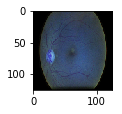

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [13]:
listing = os.listdir(train_dir) 
np.size(listing)

35126

In [21]:
from PIL import Image

# input image dimensions
img_rows, img_cols = 224, 224

immatrix = []
imlabel = []

for file in listing:
    base = os.path.basename(train_dir + file)
    fileName = os.path.splitext(base)[0]
    imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
    im = Image.open(train_dir + file)   
    img = im.resize((img_rows,img_cols))
    rgb = img.convert('RGB')                                                                                                   
    immatrix.append(np.array(rgb).flatten())

IndexError: index 0 is out of bounds for axis 0 with size 0